# Coronavirus Herd Immunity

## Introduction

Given the virality of coronavirus and the difficulting of quickly creating a vaccine, it seems like a real possibility that this pandemic will end through achieving herd immunity. In that scenario, I want to know:

- At what prevalence will we achieve herd immunity?
- How many people will die if we acquire herd immunity naturally, instead of through a vaccine?
- How will deaths be distributed by age and underlying condition status?
- How many fewer people will die if we can protect vulnerable people well?


### Vulnerable Populations

Coronavirus strikes hardest elderly people and people with underlying conditions. Knowing the IFR among these segments of people can help us understand more finely the risk to specific individuals. This has implication for who we focus on helping and how.

### Herd Immunity

At what prevalence will herd immunity to coronavirus be achieved? 

- https://www.weforum.org/agenda/2020/05/coronavirus-pandemic-last-2-years/
  - herd immunity at 60%-70% prevalence. 
  - [the report](https://www.cidrap.umn.edu/sites/default/files/public/downloads/cidrap-covid19-viewpoint-part1_0.pdf)

Theoretically, herd immunity works by having immune individuals get in the way of the virus moving from an infected person to a susceptible one. The prevalence of immune people lowers R, the repoduction number of the virus. This is also what social distancing does. What is the R0 (the basic reproduction number) of coronavirus? We want to examine a range of possible reproduction (R) numbers and their corresponding herd immunity prevalences. 

- https://academic.oup.com/cid/article/52/7/911/299077 
  - Details the relationship between R0 and the corresponding recovered prevalence.
  - figure: [(H)erd rate vs R0](https://academic.oup.com/view-large/figure/3862687/cidcir007f02_ht.gif).
  - 40%-80% prevalence for herd immunity, depending on what the R0 of coronavirus.

So what is the most likely value of R0? Around 2-2.5 according to [this NY Times article](https://www.nytimes.com/2020/04/23/world/europe/coronavirus-R0-explainer.html). Eyeballing the [(H)erd rate vs R0](https://academic.oup.com/view-large/figure/3862687/cidcir007f02_ht.gif), it looks like the corresponding recovered prevalence at herd immunity is 45-60%.

What is R0, the basic reproduction number? It a measure of virality that assumes everyone is susceptible and no mitigation is occurring. https://en.wikipedia.org/wiki/Basic_reproduction_number. The effective reproduction number, R, can take into account recovered individuals, social distancing measures, weather. What this means is that herd immunity can be achieved at *lower recovered prevalences* corresponding to a lower R. Nicky Case has a great piece describing this: https://ncase.me/covid-19/. If R is 1.5, herd immunity could be achieved with 35% recovered.

What determines R? Summer weather, small gatherings, handwashing, and masks would all reduce R down from R0. 

The effective reproduction number can be thought of as a function of R0, the weather, social distancing, work-from-home, masks, stay-at-home orders, contact tracing, surveillance testing, temperature testing.

$$
R = R_0 + R_\text{biology} + R_\text{weather} + R_\text{social_distancing} + R_\text{stay_at_home} + ...
$$

*DATA NEEDED: what are the contributions to R of different policies?*

This analysis assumes that the current fatality rates hold. If vulnerable populations are protected or therapeutics are developed, the fatality rate would improve. Protecting the vulnerable could be approximated as reducing the proportion of the 65-74 and 75+ age bands that get infected at a herd prevalence level. Therapeutics could be modeled by reducing the IFR across all age bands, by reducing the number of deaths by a therapeutic factor like 0.9 or 0.5.

As the prevalence of infections rises to a level where herd immunity is achieved, people of all ages will become infected and some of them will die. Here we consider a range of herd immunity prevalences. Prevalence of immune individuals is on factor in the R equation.



## Herd Immunity Links

- https://www.jhsph.edu/covid-19/articles/achieving-herd-immunity-with-covid19.html
  Estimate of 70% prevalence by the pandemic's end
- https://fivethirtyeight.com/features/without-a-vaccine-herd-immunity-wont-save-us/
  538 article on herd immunity. Using R0=1.6 (for social distancing with an open economy)
  and a IFR of 0.4%, prevalence is at 64% by the pandemic's end.
- https://rt.live/
  Estimate of current and future R_t (effective reproduction number) using 
  bayesian magic and covidtracking.com data, I think.
 


## Results

In [2]:
import datetime
import itertools
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pandas import to_datetime
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

from IPython.display import HTML 
from coronavirus import data
from coronavirus.data import (
    load_cdc_deaths_by_age,
    load_census_state_population_by_age_data,
    load_covidtracking_state_data, 
    load_nyc_age_comorbidity_death_data, 
    load_ma_data_by_date_age,
    fill_before_first, before_threshold, make_days_since,
    add_derived_values_cols,
    to_prevalence_dataframe,
    add_age_dimension,
    add_condition_dimension,
    add_herd_cols,
    add_herd_dimension,
    add_infections_dimension,
    add_prevalence_cols,
    add_prevalence_dimension,
    MA_CONDITION_P,
    NYC_CONDITION_P,
)
from coronavirus.viz import plot_trajectories, days_since_trim, prioritize_entities


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [690]:
states_df = (load_covidtracking_state_data(download=False, cache=True)
             .pipe(add_derived_values_cols))
# takes a few seconds to load
pop_nyc = load_census_state_population_by_age_data(bands='nyc')
_, dc_nyc = load_nyc_age_comorbidity_death_data()

pop_ma = load_census_state_population_by_age_data(bands='ma')
dc_ma = load_ma_data_by_date_age().groupby('age_band').last().reset_index()

load_ma_data_by_age url: https://www.mass.gov/doc/covid-19-raw-data-may-10-2020/download
yester_url: https://www.mass.gov/doc/covid-19-raw-data-may-9-2020/download


## Infection Fatality Rate by State

The Erickson estimate of prevalence is cases/tests. This is motivated by the goal of modeling the prevalence to get a better estimate of the infection fatality rate (IFR) of coronavirus. As a first approximation, assuming that people are tested at random (which they are not) leads to the Erickson estimate of prevalence.

The Erickson estimate of infection fatality rate is deaths / (population * prevalence). As a first approximation, assuming that reported deaths is a relatively accurate count leads to the Erickson estimate of infection fatality rate.

The adjusted Erickson estimate scales the Erickson estimate by a factor s.t the NY state adjusted estimate equals the NY seroprevalence study estimate of 12.3% on May 2nd.

Based on antibody seroprevalence study data, it looks like the case fatality rate is pessimistic by around a factor of 8 or 80 depending on the location and study results. Based on those studies it looks like the Erickson estimate is optimistic by around a factor of 2, based on New York state, the state which we have seroprevalance data for.

,date,entity,method,prevalence,ifr,cfr,population
42,2020-05-09,South Dakota,adjusted_confirmed,0.029322,0.001311,0.010021,884659
45,2020-05-09,Utah,adjusted_confirmed,0.014554,0.001415,0.010814,3205958
51,2020-05-09,Wyoming,adjusted_confirmed,0.008507,0.001422,0.010870,578759
27,2020-05-09,Nebraska,adjusted_confirmed,0.030950,0.001537,0.011748,1934408
43,2020-05-09,Tennessee,adjusted_confirmed,0.016533,0.002143,0.016387,6829174
15,2020-05-09,Iowa,adjusted_confirmed,0.028281,0.002824,0.021592,3155070
16,2020-05-09,Kansas,adjusted_confirmed,0.017716,0.003042,0.023256,2913314
3,2020-05-09,Arkansas,adjusted_confirmed,0.009493,0.003072,0.023485,3017804
34,2020-05-09,North Dakota,adjusted_confirmed,0.014687,0.003127,0.023907,762062
1,2020-05-09,Alaska,adjusted_confirmed,0.003950,0.003460,0.026455,731545


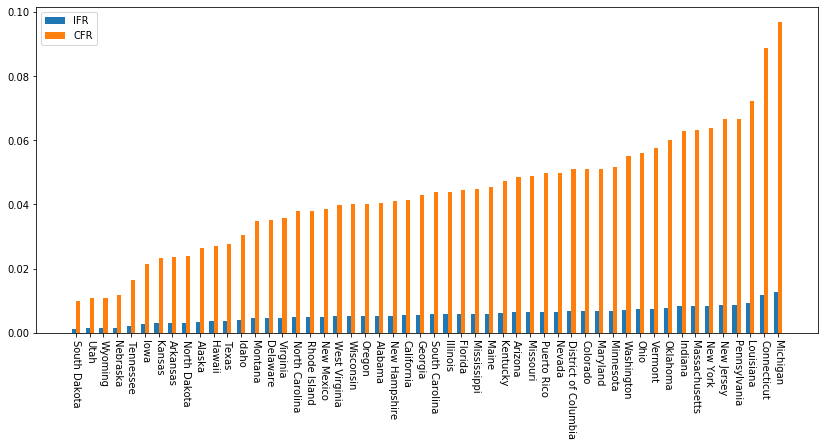

In [711]:
df = (to_prevalence_dataframe(states_df, dc=dc_nyc, pop=pop_nyc, 
              methods=['adjusted_confirmed'],
              latest=True)
      .loc[:, ['date', 'entity', 'method', 'prevalence', 'ifr', 'cfr', 'population']]
      .sort_values(by=['ifr'])
     )
display(df)

idx = np.arange(len(df['entity']))
width = 0.15
fig, ax = plt.subplots(figsize=[14,6])
plt.bar(idx - width, df['ifr'], width*2, label='IFR')
plt.bar(idx + width, df['cfr'], width*2, label='CFR')
plt.legend()
plt.xticks(ticks=idx, labels=df['entity'], rotation=-90)
plt.ylabel('')
plt.show()


### Prevalence and IFR by Age

,date,method,age_band,deaths,cases,tests,population,prevalence,ifr,cfr
0,2020-05-09,adjusted_confirmed,0-19,0.000000,44792.919605,2.159524e+06,81982665,0.004177,0.000000,0.000000
1,2020-05-09,adjusted_confirmed,20-29,49.664253,162268.006940,1.213757e+06,45435335,0.027304,0.000040,0.000306
2,2020-05-09,adjusted_confirmed,30-39,215.211765,191695.597759,1.163809e+06,43699605,0.033537,0.000147,0.001123
3,2020-05-09,adjusted_confirmed,40-49,629.080543,188293.145684,1.073354e+06,40461436,0.035578,0.000437,0.003341
4,2020-05-09,adjusted_confirmed,50-59,2599.095928,214336.382578,1.147244e+06,42825549,0.038264,0.001586,0.012126
5,2020-05-09,adjusted_confirmed,60-69,7284.090498,175389.165208,9.985865e+05,37418544,0.035835,0.005432,0.041531
6,2020-05-09,adjusted_confirmed,70-79,16422.313122,123918.028499,6.039109e+05,22672489,0.041786,0.017334,0.132526
7,2020-05-09,adjusted_confirmed,80+,45972.543891,197993.753728,3.429819e+05,12671811,0.119455,0.030371,0.232192


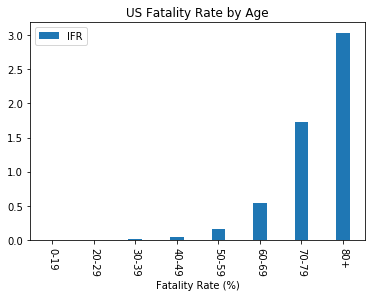

In [715]:
df = states_df; dc = dc_ma; pop = pop_ma
df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
df = add_prevalence_dimension(df)
methods = ['adjusted_confirmed']
df = df.loc[df['method'].isin(methods), :]
df = add_age_dimension(df, pop=pop, dc=dc, groupby=['date', 'entity'])
age_bands = df['age_band'].unique()
df = df.loc[df['age_band'].isin(age_bands), :]
# most recent day
df = df.groupby(['entity', 'method', 'age_band']).last().reset_index()
# summarize across entities
df = df.groupby(['date', 'method', 'age_band'])[['deaths', 'cases', 'tests', 'population']].sum().reset_index()               
df = add_prevalence_cols(df)
display(df)
idx = np.arange(len(df['age_band']))
width = 0.33
fig, ax = plt.subplots()
plt.bar(idx, df['ifr'] * 100, width, label='IFR')
# plt.bar(idx + width, df['cfr'] * 100, width, label='CFR')
plt.legend()
plt.xticks(ticks=idx, labels=df['age_band'], rotation=-90)
plt.xlabel('Fatality Rate (%)')
plt.title('US Fatality Rate by Age')
plt.show()


load_ma_data_by_age url: https://www.mass.gov/doc/covid-19-raw-data-may-7-2020/download
yester_url: https://www.mass.gov/doc/covid-19-raw-data-may-6-2020/download


This is my latest estimates of Infection Fatality Rates for people of different ages and with different underlying condition status. This is for the whole United States, looking only at people 65 to 74, and people 75+ and over. If you know you either have an underlying condition (condition = True) or you do not have an underlying condition (condition = False), you can see IFR, an estimate of how likely a person who catches coronavirus is to die. If you have an underlying condition and are 65 to 74, your chance of dying is aroooouund 1.3%, 13 out of 1000. 
If you are healthy your chance is only 0.02%, or .2 out of 1000. That's good news.

> All models are wrong, but some are useful

https://en.wikipedia.org/wiki/All_models_are_wrong


In [678]:
def ifr_by_age(df):
    df = df.loc[:, ['date', 'entity', 'deaths', 'cases', 'tests', 'population']]
    groupby_sub = []

    entities = df['entity'].unique()
    df = df.loc[df['entity'].isin(entities), :]

    df = add_prevalence_dimension(df)
    pipes = [add_prevalence_cols]
#     methods = df['method'].unique()
    methods = ['miami_confirmed']
    groupby_sub.append('method')
    df = df.loc[df['method'].isin(methods), :]
    df = add_age_dimension(df, pop=pop, dc=dc, groupby=['date', 'entity'])
    age_bands = df['age_band'].unique()
    groupby_sub.append('age_band')
    df = df.loc[df['age_band'].isin(age_bands), :]

#     df = add_condition_dimension(df, p=condition_p)
#     condition_prevalences = df['condition_prevalence'].unique()
#     groupby_sub.extend(['condition', 'condition_prevalence'])
#     df = df.loc[df['condition_prevalence'].isin(condition_prevalences), :]

    # df = add_herd_dimension(df)
    # herds = df['herd'].unique()
    # pipes.append(add_herd_cols)
    # groupby_sub.append('herd')
    # df = df.loc[df['herd'].isin(herds), :]

    # most recent day
    df = df.groupby(['entity'] + groupby_sub).last().reset_index()

    # summarize across entities
    # print(f'groupby_sub: {groupby_sub}')
    df = df.groupby(['date'] + groupby_sub)[['deaths', 'cases', 'tests', 'population']].sum().reset_index()

    # compute prevalence, ifr, herd_deaths, ...
    for func in pipes:
        df = func(df)
    
    sortby = [
#         'condition_prevalence', 
        'age_band',     
    ]
    df.sort_values(by=sortby)
    return df



# prettify
def prettify(df):
    for col in ['deaths', 'cases', 'tests', 'population',
                    'herd_cases', 'herd_deaths', 'herd_deaths_per_million'
               ]:
        if col in df.columns:
            df[col] = df[col].round()

    return df

dc, pop, age_bands, condition_p, cond_ent = (dc_nyc, pop_nyc, ['65 to 74', '75+'], NYC_CONDITION_P, 'New York City')
display(prettify(ifr_by_age(states_df)))
dc, pop, age_bands, condition_p, cond_ent = (dc_ma,  pop_ma, ['60-69', '70-79', '80+'], MA_CONDITION_P, 'Massachusetts')
display(prettify(ifr_by_age(states_df)))

,date,method,age_band,deaths,cases,tests,population,prevalence,ifr,cfr
0,2020-05-06,miami_confirmed,0 to 17,32.0,27865.0,1724515.0,73543774.0,0.005898,0.000074,0.001150
1,2020-05-06,miami_confirmed,18 to 44,2708.0,448147.0,2782170.0,117288132.0,0.059476,0.000388,0.006044
2,2020-05-06,miami_confirmed,45 to 64,14974.0,448380.0,1997766.0,83904335.0,0.083184,0.002145,0.033396
3,2020-05-06,miami_confirmed,65 to 74,16566.0,152223.0,723484.0,30492316.0,0.077709,0.006991,0.108828
4,2020-05-06,miami_confirmed,75+,32865.0,138955.0,526009.0,21938877.0,0.098591,0.015194,0.236516


,date,method,age_band,deaths,cases,tests,population,prevalence,ifr,cfr
0,2020-05-06,miami_confirmed,0-19,0.0,41926.0,1923278.0,81982665,0.007961,0.000000,0.000000
1,2020-05-06,miami_confirmed,20-29,46.0,151883.0,1080986.0,45435335,0.052035,0.000019,0.000300
2,2020-05-06,miami_confirmed,30-39,197.0,179427.0,1037060.0,43699605,0.063913,0.000071,0.001101
3,2020-05-06,miami_confirmed,40-49,577.0,176242.0,956345.0,40461436,0.067803,0.000210,0.003275
4,2020-05-06,miami_confirmed,50-59,2385.0,200619.0,1022443.0,42825549,0.072920,0.000764,0.011888
5,2020-05-06,miami_confirmed,60-69,6684.0,164164.0,889900.0,37418544,0.068292,0.002616,0.040717
6,2020-05-06,miami_confirmed,70-79,15070.0,115987.0,538150.0,22672489,0.079632,0.008347,0.129927
7,2020-05-06,miami_confirmed,80+,42187.0,185322.0,305782.0,12671811,0.227650,0.014624,0.227639


In [640]:
nyc_age_bands = ['0 to 17', '18 to 44', '45 to 64', '65 to 74', '75+'],
ma_age_bands = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'],
methods = ['miami_confirmed']; 
condition_prevalences = None # [0.5]
latest = True; overall = True

nyc = (dc_nyc, pop_nyc, ['65 to 74', '75+'], NYC_CONDITION_P, 'New York City')
ma = (dc_ma,  pop_ma, ['60-69', '70-79', '80+'], MA_CONDITION_P, 'Massachusetts')
for dc, pop, age_bands, condition_p, cond_ent in [nyc, ma]:
    print('Coronavirus IFR by Age and Underlying Condition Status ')
    print(f'- {cond_ent} underlying condition and age data')
    display(to_prevalence_dataframe(
        states_df, dc=dc, pop=pop, methods=methods, age_bands=age_bands, condition_prevalences=condition_prevalences, 
        condition_p=condition_p, latest=latest, overall=overall)
          .loc[:, ['age_band', 'condition', 'prevalence', 'ifr', 'cfr']]
          .sort_values(by=['age_band', 
                           'condition'
                          ]).reset_index(drop=True))
    print('\n')
    

Coronavirus IFR by Age and Underlying Condition Status 
- New York City underlying condition and age data


,age_band,condition,prevalence,ifr,cfr
0,65 to 74,False,0.077709,0.000112,0.001739
1,65 to 74,True,0.077709,0.013871,0.215916
2,75+,False,0.098591,0.000243,0.003780
3,75+,True,0.098591,0.030146,0.469251




Coronavirus IFR by Age and Underlying Condition Status 
- Massachusetts underlying condition and age data


,age_band,condition,prevalence,ifr,cfr
0,60-69,False,0.068292,-0.509022,-7.923459
1,60-69,True,0.068292,0.514254,8.004892
2,70-79,False,0.079632,-1.624292,-25.283783
3,70-79,True,0.079632,1.640985,25.543637
4,80+,False,0.227650,-2.845845,-44.298525
5,80+,True,0.227650,2.875093,44.753803


In [582]:
dc_nyc.head()

,age_band,min_age,max_age,cases,deaths,deaths_per_case,entity
0,0 to 17,0.0,17.0,3711,6,0.001617,New York
1,18 to 44,18.0,44.0,59684,507,0.008495,New York
2,45 to 64,45.0,64.0,59715,2803,0.046940,New York
3,65 to 74,65.0,74.0,20273,3101,0.152962,New York
4,75+,75.0,200.0,18506,6152,0.332433,New York


In [ ]:
df = states_df
df = add_prevalence_dimension(df)
df = add_prevalence_cols(df)
print('United States Coronavirus Prevalence and Infection Fatality Rate')
dg = df.groupby(['entity', 'method']).last().reset_index()
dg = dg.groupby(['date', 'method'])[['deaths', 'cases', 'tests', 'population']].sum().reset_index()
dg = add_prevalence_cols(dg)
dg.loc[:, ['date', 'method', 'deaths', 'cases', 'tests', 'population', 'prevalence', 'ifr', 'cfr']]


In [587]:
# plt.hist(df['prevalence'], bins='auto')
plt.plot(df['prevalence'], df['ifr'], '.')
plt.xlabel('prevalence')
plt.ylabel('IFR')
plt.title('IFR vs Prevalence in States')
plt.show()
df

KeyError: 'prevalence'

Here are the prevalence estimates and their corresponding infection fatality rates for New York. Note that the adjusted prevalence matches the NY state antibody seroprevalence survey results announced on 05/02.

In [463]:

print(f'Estimated Coronavirus Prevalence and IFR for {state}')
HTML(df.loc[(df['entity'] == state) 
#             & (df['method'] == 'adjusted_confirmed')
            & (df['date'] == to_datetime('2020-05-05'))
            ,
       ['date', 'entity', 'method', 'prevalence', 'ifr']]
     .rename(columns={'method': 'estimation_method'})
     .to_html(index=False)
    )

Estimated Coronavirus Prevalence and IFR for Rhode Island


date,entity,estimation_method,prevalence,ifr
2020-05-05,Rhode Island,confirmed,0.009376,0.035739
2020-05-05,Rhode Island,adjusted_confirmed,0.071685,0.004675
2020-05-05,Rhode Island,erickson,0.129954,0.002579
2020-05-05,Rhode Island,adjusted_erickson,0.048981,0.006842
2020-05-05,Rhode Island,miami_confirmed,0.145954,0.002296


Here are the prevalence and IFR for the US overall.

In [505]:
df = states_df
df = add_prevalence_dimension(df)
df = add_prevalence_cols(df)
print('United States Coronavirus Prevalence and Infection Fatality Rate')
dg = df.groupby(['entity', 'method']).last().reset_index()
dg = dg.groupby(['date', 'method'])[['deaths', 'cases', 'tests', 'population']].sum().reset_index()
dg = add_prevalence_cols(dg)
dg.loc[:, ['date', 'method', 'prevalence', 'ifr', 'cfr']]


United States Coronavirus Prevalence and Infection Fatality Rate


,date,method,prevalence,ifr,cfr
0,2020-05-05,adjusted_confirmed,0.027574,0.007145,0.054624
1,2020-05-05,adjusted_erickson,0.059751,0.003297,0.054624
2,2020-05-05,confirmed,0.003607,0.054624,0.054624
3,2020-05-05,erickson,0.158527,0.001243,0.054624
4,2020-05-05,miami_confirmed,0.056142,0.003509,0.054624


A plot of how the prevalence estimates have changed over time. The confirmed prevalence is cases / population size. The Erickson prevalence is cases / tests. The adjusted Erickson prevalance scales Erickson prevalence s.t. it equals the NY state serprevalence estimate released on 2020-05-02.

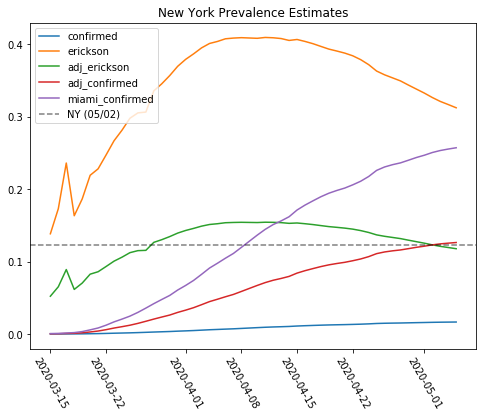

In [346]:
def plot_ny_prevalence_trend(df):
    entity = 'New York'
    df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'))]
    dates = df.loc[(df['entity'] == entity) & (df['method'] == 'confirmed'), 'date']
    confs = df.loc[(df['entity'] == entity) & (df['method'] == 'confirmed'), 'prevalence']
    erics = df.loc[(df['entity'] == entity) & (df['method'] == 'erickson'), 'prevalence']
    aes = df.loc[(df['entity'] == entity) & (df['method'] == 'adjusted_erickson'), 'prevalence']
    acs = df.loc[(df['entity'] == entity) & (df['method'] == 'adjusted_confirmed'), 'prevalence']
    mcs = df.loc[(df['entity'] == entity) & (df['method'] == 'miami_confirmed'), 'prevalence']
    plt.subplots(figsize=(8,6))
    plt.plot(dates, confs, label='confirmed')
    plt.plot(dates, erics, label='erickson')
    plt.plot(dates, aes, label='adj_erickson')
    plt.plot(dates, acs, label='adj_confirmed')
    plt.plot(dates, mcs, label='miami_confirmed')
    ny_seroprevalence = 0.123
    plt.axhline(y=ny_seroprevalence, linestyle='--', color='k', alpha=0.5, label='NY (05/02)')
    # plt.axvline(x=pd.to_datetime('2020-05-02'), linestyle='--', color='k', alpha=0.5)
    plt.xticks(rotation=-60)
    plt.legend()
    plt.title(f'{entity} Prevalence Estimates')
    plt.show()
    
plot_ny_prevalence_trend(df)

#### Trends in Infection Fatality Rate Estimations by State

The next figure shows trends in infection fatality rate estimations by state. We can see that there is a broad range of IFR by state. 

Erickson IFR estimates show a strong increasing trend across most/all states. This is consistent with the estimate being an underestimate of IFR that is converging to the true value as more testing occurs.

Confirmed IFR (i.e. case fatality rate) estimates show variable trends, increasing for some states, stable for many states and decreasing somewhat for some states. This suggests that CFR is a more stable and less biased estimate over time than the Erickson estimate. It also suggests that the adjusted confirmed IFR estimate might be the best predictor of future IFR values.

Confirmed IFRs range from around 0.01 to 0.09, a 9-fold difference. Erickson IFRs range from around 0.0002 to 0.0030, a 15-fold difference. These ranges are very different. The adjusted ranges are much closer. Adjusted Confirmed IFRs range from around 0.001 to 0.012. Adjusted Erickson IFRs range from arond 0.0005 to 0.008. 

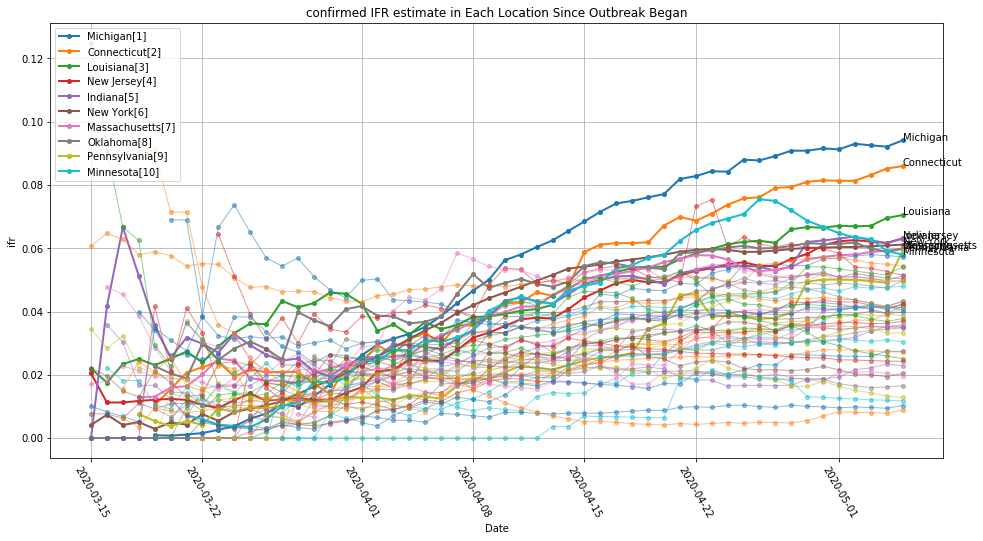

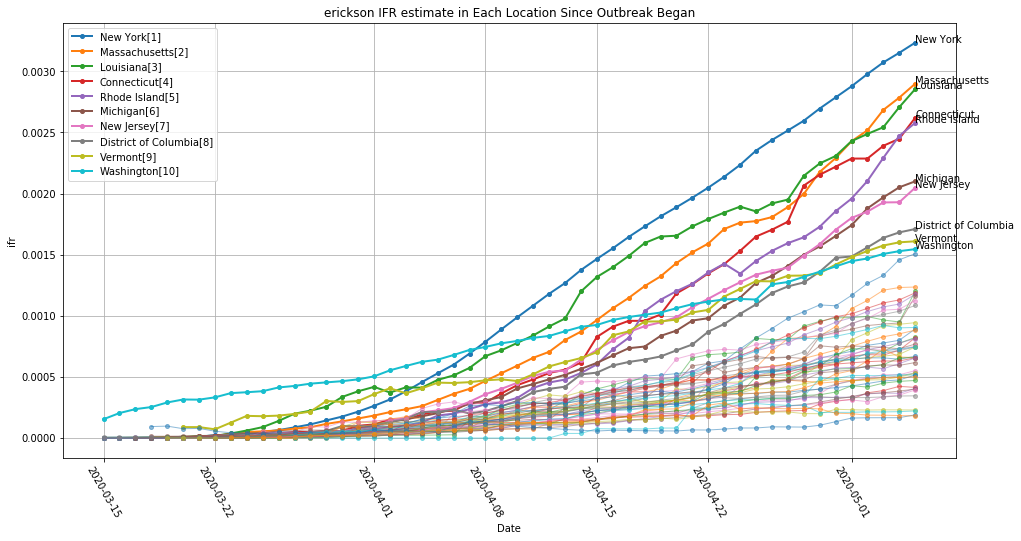

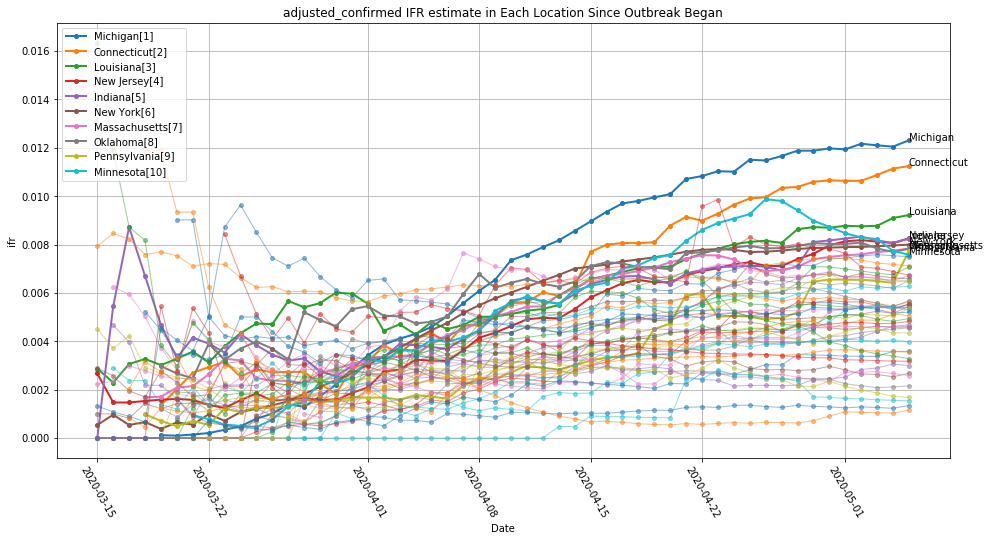

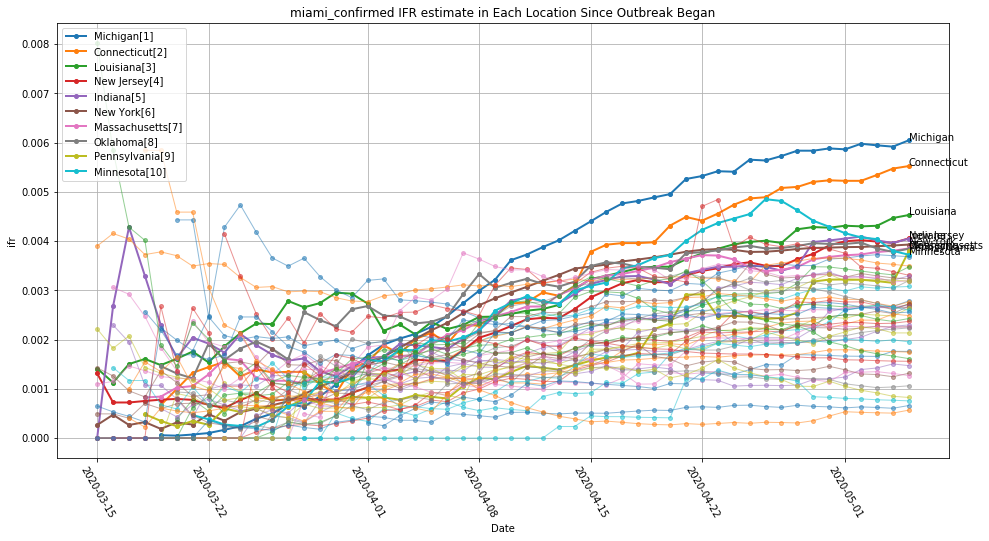

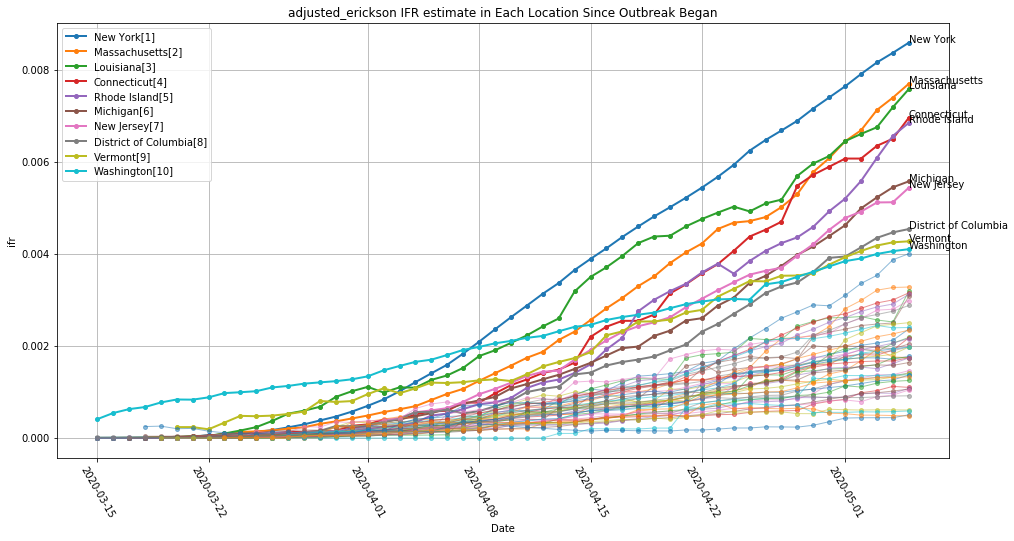

In [348]:
def plot_ifr_trend_by_state(df):
    index_col = 'date'; df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'))]
#     index_col = 'days_since'; df = df.loc[~before_threshold(df, col='deaths', thresh=5)].copy()
#     df['days_since'] = make_days_since(df, col='deaths', thresh=5)
    
    values_col='ifr'; log_yaxis = False; ascending = False; show_legend = True
    n_top = 10; n_show = 55; rank = False;
    method = 'confirmed'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'erickson'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'adjusted_confirmed'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'miami_confirmed'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )
    method = 'adjusted_erickson'
    title = f'{method} IFR estimate in Each Location Since Outbreak Began'
    plot_trajectories(
        df.loc[(df['method'] == method)], index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
        log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
    )

plot_ifr_trend_by_state(df)

## Infection Fatality Rate and Herd Immunity




In [352]:
df = states_df
df = add_prevalence_dimension(df)
df = add_prevalence_cols(df)
df = add_herd_dimension(df)
df = add_herd_cols(df)
df[df['entity'] == 'California'].tail(10).loc[:, [
    'date', 'entity', 'method', 'herd', 'cases', 'deaths', 'prevalence', 'ifr', 
    'herd_deaths', 'herd_deaths_per_million',
]]

,date,entity,method,herd,cases,deaths,prevalence,ifr,herd_deaths,herd_deaths_per_million
4610,2020-05-05,California,adjusted_confirmed,0.8,56212.0,2317.0,0.010877,0.005391,170422.388701,4313.156177
4611,2020-05-05,California,erickson,0.4,56212.0,2317.0,0.072076,0.000814,12858.698740,325.435973
4612,2020-05-05,California,erickson,0.6,56212.0,2317.0,0.072076,0.000814,19288.048111,488.153960
4613,2020-05-05,California,erickson,0.8,56212.0,2317.0,0.072076,0.000814,25717.397481,650.871946
4614,2020-05-05,California,adjusted_erickson,0.4,56212.0,2317.0,0.027166,0.002159,34115.644038,863.420012
4615,2020-05-05,California,adjusted_erickson,0.6,56212.0,2317.0,0.027166,0.002159,51173.466057,1295.130017
4616,2020-05-05,California,adjusted_erickson,0.8,56212.0,2317.0,0.027166,0.002159,68231.288076,1726.840023
4617,2020-05-05,California,miami_confirmed,0.4,56212.0,2317.0,0.022145,0.002648,41851.436847,1059.202284
4618,2020-05-05,California,miami_confirmed,0.6,56212.0,2317.0,0.022145,0.002648,62777.155271,1588.803426
4619,2020-05-05,California,miami_confirmed,0.8,56212.0,2317.0,0.022145,0.002648,83702.873695,2118.404568


Here are the herd deaths for the US overall.

In [361]:
print('United States Coronavirus Deaths at Herd Immunity Prevalence')
dg = df.groupby(['entity', 'method', 'herd']).last().reset_index()
dg = dg.groupby(['date', 'method', 'herd'])[['deaths', 'cases', 'tests', 'population']].sum().reset_index()
dg = add_prevalence_cols(dg)
dg = add_herd_cols(dg)
dg = dg.loc[:, ['method', 'herd', 'ifr', 'herd_deaths', 'herd_deaths_per_million']]
dg['herd_deaths'] = dg['herd_deaths'].round()
dg['herd_deaths_per_millon'] = dg['herd_deaths_per_million'].round()
HTML(dg.set_index(['method', 'herd']).to_html())# to_html(index=False))



United States Coronavirus Deaths at Herd Immunity Prevalence


## Estimates of Infection Fatality Rate by Age

Segmenting the infection fatality rate by age requires knowing:

- the prevalence of infection. We have 3 estimates: confirmed_prevalence, erickson_prevalence, and adjusted_erickson_prevalence.
- population of the age band. We have estimates for population by state (or county) and census age_groups, or nyc_age_bands, or ma_age_bands.
- ifr_age = deaths_age * (population_age * prevalence)
- prevalence at state-level is available through: confirmed, erickson, adjusted, otherwise-modeled, ny antibody seroprevalence studies, county seroprevalence studies.
- deaths by age band. We have data for:
  - NYC
  - Massachusetts
  - ...more every day?

In [664]:
df = states_df
df = add_prevalence_dimension(df)
df = add_age_dimension(df, pop, dc, groupby=['date', 'entity', 'method'])
df = df.loc[:, ['date', 'entity', 'method', 'age_band', 'deaths', 'cases', 'tests', 'population']]
df = add_prevalence_cols(df)


### Latest IFR by age by state

In [666]:
# df.groupby(['entity', 'method', 'age_band']).last().reset_index().loc[lambda d: d['entity'] == 'New York', :].head(30)
# df = add_prevalence_age_cols(df)

dg = df.groupby(['entity', 'method', 'age_band']).last().reset_index()
dg.loc[
    lambda d: (d['method'].isin(['miami_confirmed'])) 
#     & (d['entity'] == 'Massachusetts')
    ,
    ['entity', 'method', 'age_band', 'prevalence', 'ifr', 'cfr']
]

,entity,method,age_band,prevalence,ifr,cfr
32,Alabama,miami_confirmed,0-19,0.003785,0.000000,0.000000
33,Alabama,miami_confirmed,20-29,0.025088,0.000014,0.000215
34,Alabama,miami_confirmed,30-39,0.032454,0.000051,0.000790
35,Alabama,miami_confirmed,40-49,0.032209,0.000151,0.002349
36,Alabama,miami_confirmed,50-59,0.033847,0.000548,0.008528
...,...,...,...,...,...,...
2035,Wyoming,miami_confirmed,40-49,0.020624,0.000044,0.000687
2036,Wyoming,miami_confirmed,50-59,0.021631,0.000160,0.002494
2037,Wyoming,miami_confirmed,60-69,0.017150,0.000549,0.008543
2038,Wyoming,miami_confirmed,70-79,0.021994,0.001751,0.027260


### Latest IFR by Age in the US

In [406]:
print('United States Coronavirus Prevalence and Infection Fatality Rate by Age')
dg = df.groupby(['entity', 'method', 'age_band']).last().reset_index()
dg = dg.groupby(['date', 'method', 'age_band'])[['deaths', 'cases', 'tests', 'population']].sum().reset_index()
dg = add_prevalence_cols(dg)
for col in ['deaths', 'cases', 'tests', 'population']:
    dg[col] = dg[col].round()
    
dg.loc[dg['method'] == 'adjusted_confirmed', ['date', 'method', 'age_band', 'prevalence', 'ifr', 'cfr']]


United States Coronavirus Prevalence and Infection Fatality Rate by Age


,date,method,age_band,prevalence,ifr,cfr
0,2020-05-05,adjusted_confirmed,0 to 17,0.002844,0.000149,0.001138
1,2020-05-05,adjusted_confirmed,18 to 44,0.028680,0.000782,0.005977
2,2020-05-05,adjusted_confirmed,45 to 64,0.040112,0.004320,0.033028
3,2020-05-05,adjusted_confirmed,65 to 74,0.037472,0.014078,0.107627
4,2020-05-05,adjusted_confirmed,75+,0.047542,0.030595,0.233907


The following figures shows trends in adjusted_confirmed IFR for each different age band. They show the distribution across states and how these IFR values have changed over time.

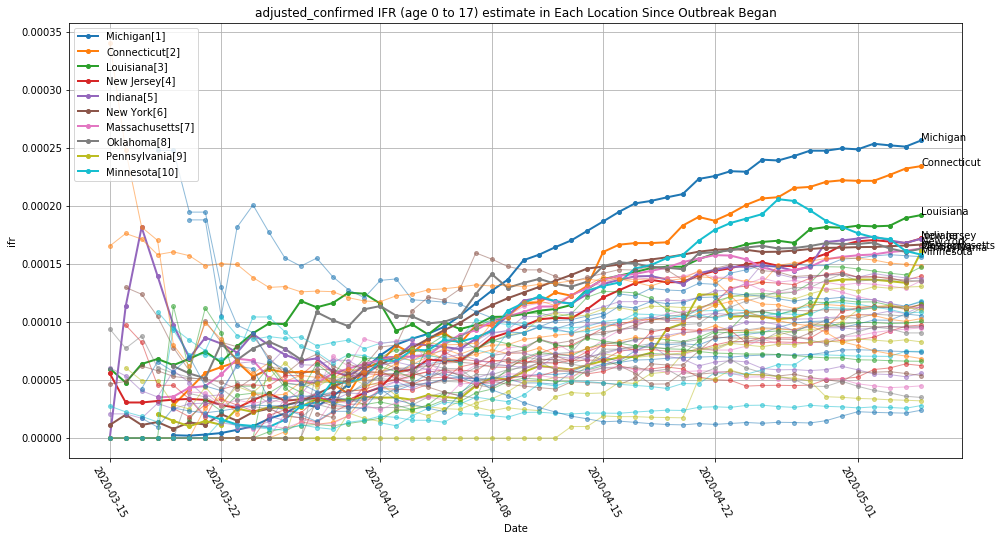

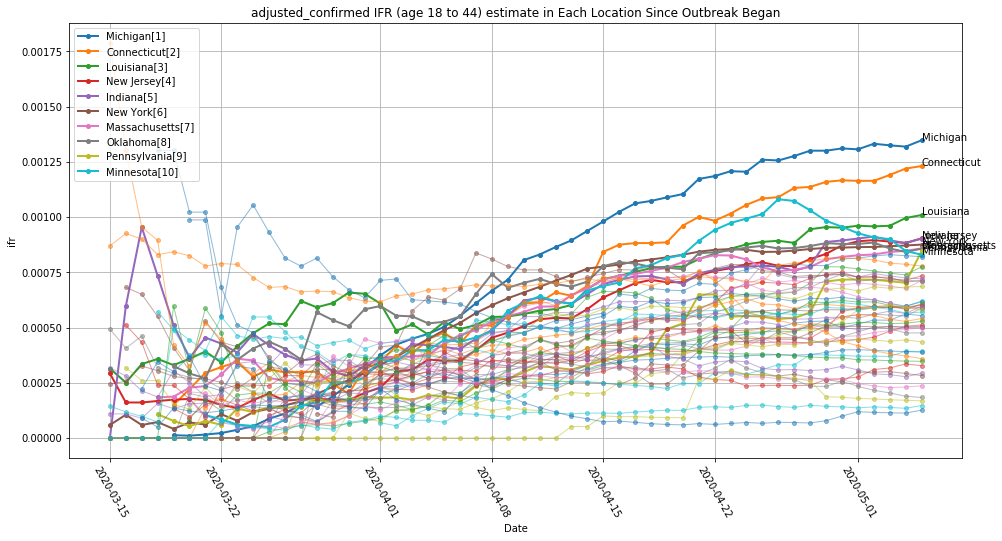

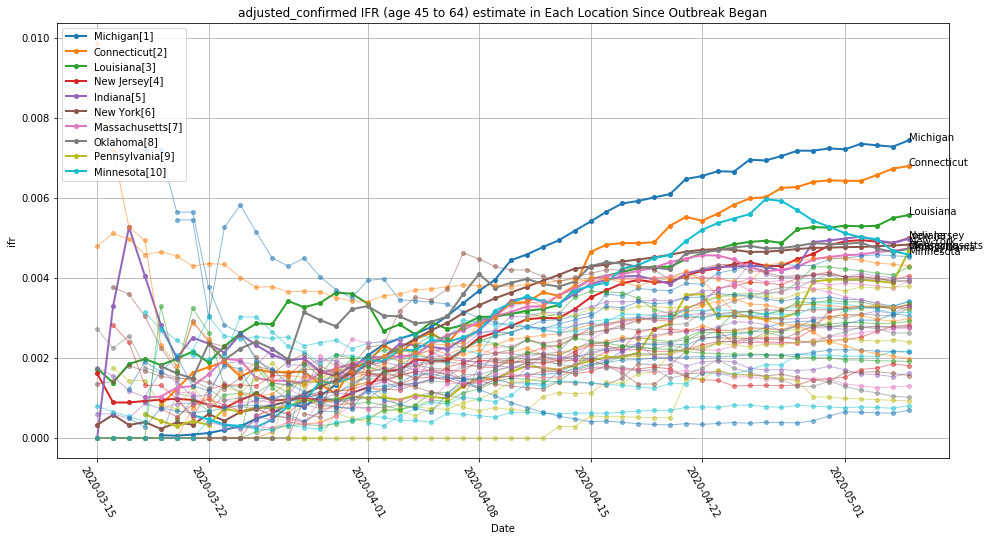

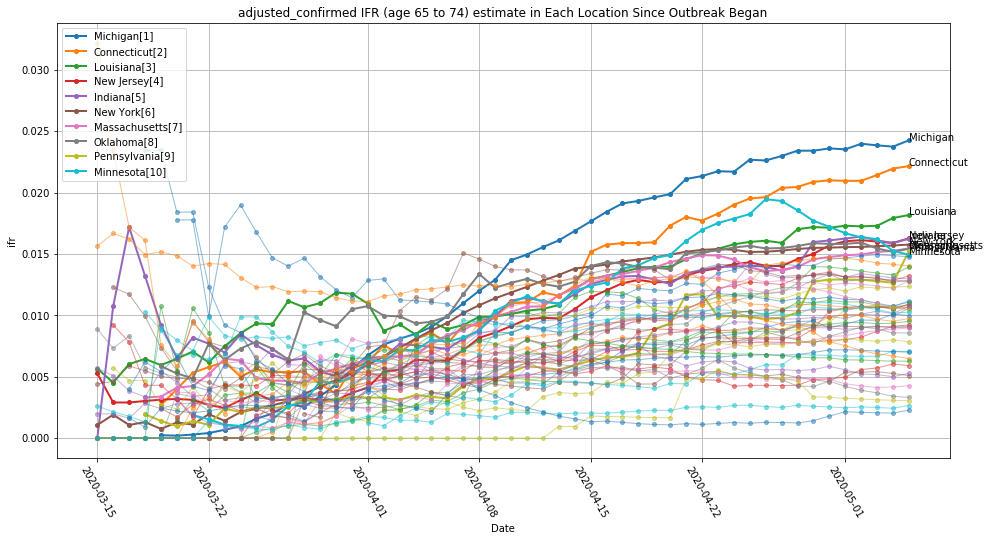

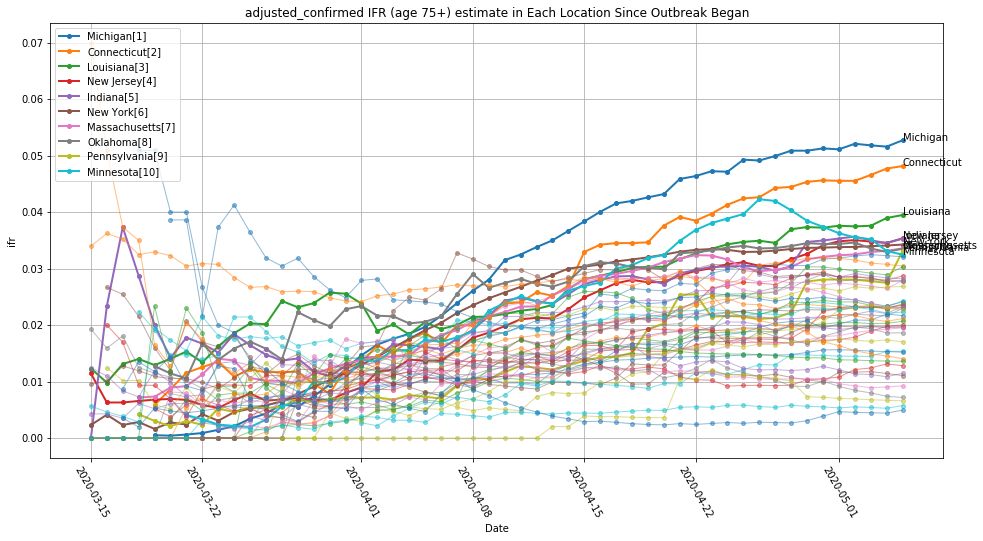

In [408]:
def plot_ifr_trend_by_state_and_age(df):
    index_col = 'date'; 
    df = df.loc[~before_threshold(df, col='date', thresh=to_datetime('2020-03-15'), 
                                  groupby=['entity', 'method', 'age_band'])]
    age_bands = df['age_band'].unique()
    
#     index_col = 'days_since'; df = df.loc[~before_threshold(df, col='deaths', thresh=5)].copy()
#     df['days_since'] = make_days_since(df, col='deaths', thresh=5)
    
    values_col='ifr'; log_yaxis = False; ascending = False; show_legend = True
    n_top = 10; n_show = 55; rank = False; method = 'adjusted_confirmed'
    
    for age_band in age_bands:
        title = f'{method} IFR (age {age_band}) estimate in Each Location Since Outbreak Began'
        plot_trajectories(
            df.loc[(df['method'] == method) & (df['age_band'] == age_band)],
            index_col=index_col, values_col=values_col, n_top=n_top, n_show=n_show,
            log_yaxis=log_yaxis, ascending=ascending, show_legend=show_legend, title=title, rank=rank
        )

plot_ifr_trend_by_state_and_age(dg)

## Infection Fatality Rate by Age and Herd Immunity



In [414]:
df = states_df
df = add_prevalence_dimension(df)
df = add_age_dimension(df, pop, dc, groupby=['date', 'entity', 'method'])
df = add_herd_dimension(df)
df = add_prevalence_cols(df)
df = add_herd_cols(df)


In [421]:
dg = df.groupby(['entity', 'method', 'age_band', 'herd']).last().reset_index()
dg = dg.loc[
    (dg['entity'] == 'Rhode Island') 
    & (dg['method'] == 'miami_confirmed')
    , 
    ['date', 'entity', 'method', 'age_band', 
                'herd', 'herd_deaths', 'herd_deaths_per_million', 'prevalence', 'ifr', 'cfr']]
dg.sort_values(by='herd')

,date,entity,method,age_band,herd,herd_deaths,herd_deaths_per_million,prevalence,ifr,cfr
2985,2020-05-05,Rhode Island,miami_confirmed,0 to 17,0.4,4.034085,19.125233,0.016803,0.000048,0.000744
2988,2020-05-05,Rhode Island,miami_confirmed,18 to 44,0.4,37.742054,100.483900,0.151764,0.000251,0.003910
2991,2020-05-05,Rhode Island,miami_confirmed,45 to 64,0.4,160.204264,555.246852,0.197668,0.001388,0.021607
2994,2020-05-05,Rhode Island,miami_confirmed,65 to 74,0.4,185.633514,1809.381685,0.188727,0.004523,0.070412
2997,2020-05-05,Rhode Island,miami_confirmed,75+,0.4,313.245661,3932.332323,0.221880,0.009831,0.153027
2986,2020-05-05,Rhode Island,miami_confirmed,0 to 17,0.6,6.051128,28.687850,0.016803,0.000048,0.000744
2989,2020-05-05,Rhode Island,miami_confirmed,18 to 44,0.6,56.613081,150.725850,0.151764,0.000251,0.003910
2992,2020-05-05,Rhode Island,miami_confirmed,45 to 64,0.6,240.306396,832.870279,0.197668,0.001388,0.021607
2995,2020-05-05,Rhode Island,miami_confirmed,65 to 74,0.6,278.450271,2714.072528,0.188727,0.004523,0.070412
2998,2020-05-05,Rhode Island,miami_confirmed,75+,0.6,469.868491,5898.498484,0.221880,0.009831,0.153027


### Coronavirus Deaths by Age in the US at Herd Immunity Prevalence

In [431]:
print('United States Coronavirus Deaths by Age at Herd Immunity Prevalence')
dg = df.groupby(['entity', 'method', 'age_band', 'herd']).last().reset_index()
dg = dg.groupby(['date', 'method', 'age_band', 'herd'])[['deaths', 'cases', 'tests', 'population']].sum().reset_index()
dg = add_prevalence_cols(dg)
dg = add_herd_cols(dg)
for col in ['deaths', 'cases', 'tests', 'population']:
    dg[col] = dg[col].round()
    
HTML(dg.loc[dg['method'] == 'miami_confirmed',
       ['date', 'herd', 'method', 'age_band', 'prevalence', 'ifr', 'cfr', 'herd_deaths', 'herd_deaths_per_million']
      ]
     .sort_values(by='herd')
     .set_index(['method', 'herd', 'age_band'])
     .drop(columns=['date'])
     .to_html())


United States Coronavirus Deaths by Age at Herd Immunity Prevalence


In [455]:

df = states_df
df = add_prevalence_dimension(df)
# df = df.loc[df['entity'] == 'New York', :]
df = df.loc[df['method'].isin(['miami_confirmed', 'confirmed']), :]
df = add_age_dimension(df, pop, dc, groupby=['date', 'entity', 'method'])
df = df.loc[df['age_band'] == '65 to 74', :]
df = add_condition_dimension(df)
df = df.loc[df['condition_prevalence'] == 0.3, :]
df = add_herd_dimension(df)
df = df.loc[df['herd'] == 0.4, :]
df = add_prevalence_cols(df)
df = add_herd_cols(df)
df = df.sort_values('condition')
df
# df = add_prevalence_cols(df)
# df = add_herd_cols(df)
# df

,date,entity,cases_per_million,cases_per_day,cases_per_day_7day_avg,cases_per_day_3day_avg,cases_per_million_per_day,cases_per_million_per_day_7day_avg,cases_per_million_per_day_3day_avg,cases_per_day_3day_avg_14day_ratio,...,deaths,condition_prevalence,condition,herd,prevalence,ifr,cfr,herd_cases,herd_deaths,herd_deaths_per_million
0,2020-03-07,Alabama,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.3,False,0.4,0.000000,NaN,NaN,136561.88,NaN,NaN
30246,2020-05-05,South Carolina,1312.366544,131.0,163.428571,89.333333,25.443247,31.741629,17.350611,1.388601,...,1.047318,0.3,False,0.4,0.023955,0.000114,0.001768,153952.68,17.487804,45.436828
15762,2020-04-06,Massachusetts,1993.325211,1337.0,1155.142857,1145.333333,193.978878,167.594103,166.170886,9.439560,...,1.657946,0.3,False,0.4,0.040961,0.000088,0.001377,183072.12,16.190513,35.375157
15756,2020-04-06,Massachusetts,1993.325211,1337.0,1155.142857,1145.333333,193.978878,167.594103,166.170886,9.439560,...,1.657946,0.3,False,0.4,0.002631,0.001377,0.001377,183072.12,252.022131,550.651036
30252,2020-03-07,South Dakota,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.3,False,0.4,0.000000,NaN,NaN,23814.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16899,2020-05-05,Michigan,4445.542777,447.0,733.571429,396.666667,44.758827,73.453683,39.718869,0.546875,...,1015.569482,0.3,True,0.4,0.005534,0.608883,0.608883,120564.24,73409.555582,243553.330847
16893,2020-05-04,Michigan,4400.783950,196.0,820.000000,531.333333,19.625794,82.107914,53.203258,0.806272,...,983.977227,0.3,True,0.4,0.085271,0.038285,0.595942,120564.24,4615.775387,15313.911944
16887,2020-05-04,Michigan,4400.783950,196.0,820.000000,531.333333,19.625794,82.107914,53.203258,0.806272,...,983.977227,0.3,True,0.4,0.005478,0.595942,0.595942,120564.24,71849.333861,238376.931206
16971,2020-03-11,Minnesota,0.886583,2.0,NaN,1.333333,0.354633,NaN,0.236422,NaN,...,NaN,0.3,True,0.4,0.000001,NaN,NaN,61221.60,NaN,NaN


In [445]:
dg = (df.loc[:, ['entity', 'date', 'method', 'age_band', 
                 'herd', 'condition', 'condition_prevalence',
                 'tests', 'cases', 'deaths', 'population']]
      .groupby(['entity', 'method', 'age_band', 'herd', 
                 'condition', 'condition_prevalence']).last().reset_index()
     )
dg = add_prevalence_cols(dg)
dg = add_herd_cols(dg)
dg

,entity,method,age_band,herd,condition,condition_prevalence,date,tests,cases,deaths,population,prevalence,ifr,cfr,herd_cases,herd_deaths,herd_deaths_per_million
0,Alabama,adjusted_confirmed,0 to 17,0.4,False,0.1,2020-05-05,21447.806609,170.926199,0.002241,981905.4,0.001331,0.000002,0.000013,392762.16,0.673621,0.686034
1,Alabama,adjusted_confirmed,0 to 17,0.4,False,0.3,2020-05-05,16681.627362,132.942600,0.002241,763704.2,0.001331,0.000002,0.000017,305481.68,0.673621,0.882044
2,Alabama,adjusted_confirmed,0 to 17,0.4,False,0.5,2020-05-05,11915.448116,94.959000,0.002241,545503.0,0.001331,0.000003,0.000024,218201.20,0.673621,1.234861
3,Alabama,adjusted_confirmed,0 to 17,0.4,True,0.1,2020-05-05,2383.089623,18.991800,0.147174,109100.6,0.001331,0.001014,0.007749,43640.24,44.234416,405.446128
4,Alabama,adjusted_confirmed,0 to 17,0.4,True,0.3,2020-05-05,7149.268870,56.975400,0.147174,327301.8,0.001331,0.000338,0.002583,130920.72,44.234416,135.148709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22945,Wyoming,miami_confirmed,75+,0.8,False,0.3,2020-05-05,492.057949,47.691339,0.051393,26044.9,0.028503,0.000069,0.001078,20835.92,1.442447,55.383104
22946,Wyoming,miami_confirmed,75+,0.8,False,0.5,2020-05-05,351.469964,34.065242,0.051393,18603.5,0.028503,0.000097,0.001509,14882.80,1.442447,77.536345
22947,Wyoming,miami_confirmed,75+,0.8,True,0.1,2020-05-05,70.293993,6.813048,3.374814,3720.7,0.028503,0.031822,0.495346,2976.56,94.720713,25457.766685
22948,Wyoming,miami_confirmed,75+,0.8,True,0.3,2020-05-05,210.881978,20.439145,3.374814,11162.1,0.028503,0.010607,0.165115,8929.68,94.720713,8485.922228


How does IFR change with condition prevalence depending on condition? As the prevalence of underlying conditions increases, people with underlying conditions are less likely to die. This follows because more of them would become cases due to the assumed uniform distribution of cases (and tests). Therefore the IFR would be lower. The opposite is true for people without an underlying condition. As the prevalence of underlying conditions increases, there are fewer cases and the IFR is higher. Since around 99% of deaths have an underlying condition, changing condition prevalence from 0.1 to 0.5 changes IFR by less than a factor of 2 for people without conditions, but around 5 fold-decrease in IFR.


In [453]:
(dg.loc[
    (dg['entity'] == 'New York')
       & (dg['method'].isin(['miami_confirmed', 'confirmed']))
       & (dg['herd'] == 0.4)
#        & (dg['condition_prevalence'] == 0.3)
        & (dg['age_band'] == '65 to 74')
       , :].sort_values('condition')
.drop(columns=['date', 'tests', 'cases', 'deaths', 'population'])
)

,entity,method,age_band,herd,condition,condition_prevalence,prevalence,ifr,cfr,herd_cases,herd_deaths,herd_deaths_per_million
14634,New York,confirmed,65 to 74,0.4,False,0.1,0.022233,0.002008,0.002008,651283.2,1307.995647,803.334492
14635,New York,confirmed,65 to 74,0.4,False,0.3,0.022233,0.002582,0.002582,506553.6,1307.995647,1032.858633
14636,New York,confirmed,65 to 74,0.4,False,0.5,0.022233,0.003615,0.003615,361824.0,1307.995647,1446.002086
14814,New York,miami_confirmed,65 to 74,0.4,False,0.1,0.346080,0.000129,0.002008,651283.2,84.028811,51.608155
14815,New York,miami_confirmed,65 to 74,0.4,False,0.3,0.346080,0.000166,0.002582,506553.6,84.028811,66.353342
14816,New York,miami_confirmed,65 to 74,0.4,False,0.5,0.346080,0.000232,0.003615,361824.0,84.028811,92.894679
14637,New York,confirmed,65 to 74,0.4,True,0.1,0.022233,1.186927,1.186927,72364.8,85891.714164,474770.684994
14638,New York,confirmed,65 to 74,0.4,True,0.3,0.022233,0.395642,0.395642,217094.4,85891.714164,158256.894998
14639,New York,confirmed,65 to 74,0.4,True,0.5,0.022233,0.237385,0.237385,361824.0,85891.714164,94954.136999
14817,New York,miami_confirmed,65 to 74,0.4,True,0.1,0.346080,0.076251,1.186927,72364.8,5517.891940,30500.419763


Feedback on my email.

> Thanks Todd this is great! Very accessible writing. 

> Can you add an analysis and conclusion for the old and sick?

> Also re: your conclusion for society (and other "open it up!" advocates)...
> 
> - About 1/3 of Americans are 60 or older
> - About the same percentage of adults have hypertension 
> - 10.5% are diabetic
> - 40% of adults are obese

> These are not additive, of course, but we are talking about simultaneously isolating and protecting between 1/3 and greater than 50% of people, while everyone else gets a disease. That is a fantasy. If we are getting to 60% antibodies, a lot of people over 60 and with comorbidities are getting it too. 

> Also, the current economic damage is not being done by a hard lockdown. Most places have a soft lockdown or less (many categories of stores open, huge categories of workers considered essential, freedom to travel and use public streets and, in most cases, open parks).  There is guidance to stay at home and many people are choosing to limit travel and activity because they have a legitimate fear for someone over 60 or with comorbidities. So, what reduction in activity is reasonable for a disease with a death rate for those over 60 and with comorbidities of, say 1%-5%? Closed stadiums, concert venues and movie theaters? Limited international travel? Increased spacing in bars and restaurants? Avoiding amusement parks and cruises? Pretty quickly it adds up to, what, 10% of the economy? 20%? Shutting that fraction of the economy for months and months is devastating and inevitable if it the disease is at epidemic levels.

## Age and Fatality

How old are people dying of coronavirus?

- Less than 1% of deaths (in the USA) come from people less than 35 years old.
- Less than 2.8% of deaths come from people less than 45 years old.
- Less than 8% of deaths come from people less than 55 years old.
- Less than 20.5% of deaths come from people less than 65 years old.

New York City reports deaths and cases by age. This allows us to look at the case fatality rate by age in NYC. See below.

In [583]:
df = load_cdc_deaths_by_age(download=False, cache=True)
df

,date,entity,deaths,age_band,min_age,max_age,cumulative_deaths,cumulative_death_pct
15,04/25/2020,United States,4.0,Under 1 year,0,0,4.0,0.011587
16,04/25/2020,United States,2.0,1–4 years,1,4,6.0,0.017381
17,04/25/2020,United States,3.0,5–14 years,5,14,9.0,0.026071
18,04/25/2020,United States,39.0,15–24 years,15,24,48.0,0.139046
19,04/25/2020,United States,263.0,25–34 years,25,34,311.0,0.900901
20,04/25/2020,United States,647.0,35–44 years,35,44,958.0,2.775122
21,04/25/2020,United States,1776.0,45–54 years,45,54,2734.0,7.919817
22,04/25/2020,United States,4347.0,55–64 years,55,64,7081.0,20.512152
23,04/25/2020,United States,7419.0,65–74 years,65,74,14500.0,42.003418
24,04/25/2020,United States,9416.0,75–84 years,75,84,23916.0,69.279569


In [584]:
age_comorbidity_df, df = load_nyc_age_comorbidity_death_data(cache=True)
# df
# display(age_comorbidity_df)
print('New York City Case Fatality Rate by Age')
(df.loc[:, ['entity', 'age_band', 'deaths_per_case', 'deaths', 'cases']]
 .rename(columns={'deaths_per_case': 'case_fatality_rate'})
)

New York City Case Fatality Rate by Age


,entity,age_band,case_fatality_rate,deaths,cases
0,New York,0 to 17,0.001617,6,3711
1,New York,18 to 44,0.008495,507,59684
2,New York,45 to 64,0.046940,2803,59715
3,New York,65 to 74,0.152962,3101,20273
4,New York,75+,0.332433,6152,18506


## Comorbidity and Fatality

Comorbidity data is available for COVID-19 fatalilies from NYC and Massachusetts.

In NYC, 99.2% of deaths have a comorbidity. Source: https://www1.nyc.gov/site/doh/covid/covid-19-data.page

In Massachusetts, 98.2% of deaths have a comorbidity. Source: https://www.mass.gov/doc/covid-19-dashboard-april-30-2020/download.


In [623]:
df, _ = load_nyc_age_comorbidity_death_data(cache=True)
df = df.loc[lambda d: (d['comorbidity'] != 'unknown') & (d['age_band'] != 'unknown')]
df = df.pivot(index='age_band', columns='comorbidity', values='deaths')
df['total'] = df.sum(axis=1)
df['comorbidity_frac'] = df['yes'] / df['total']
print('Fraction of NYC deaths with a comorbidity:')
print(f"{(df['yes'].sum() / df['total'].sum()):.3f}\n")
print('Fraction of NYC deaths with a comorbidity by age:')
df

Fraction of NYC deaths with a comorbidity:
0.992

Fraction of NYC deaths with a comorbidity by age:


comorbidity,no,yes,total,comorbidity_frac
age_band,,,,
0 to 17,0,6,6,1.000000
18 to 44,14,401,415,0.966265
45 to 64,54,2363,2417,0.977658
65 to 74,4,2255,2259,0.998229
75+,1,4140,4141,0.999759
